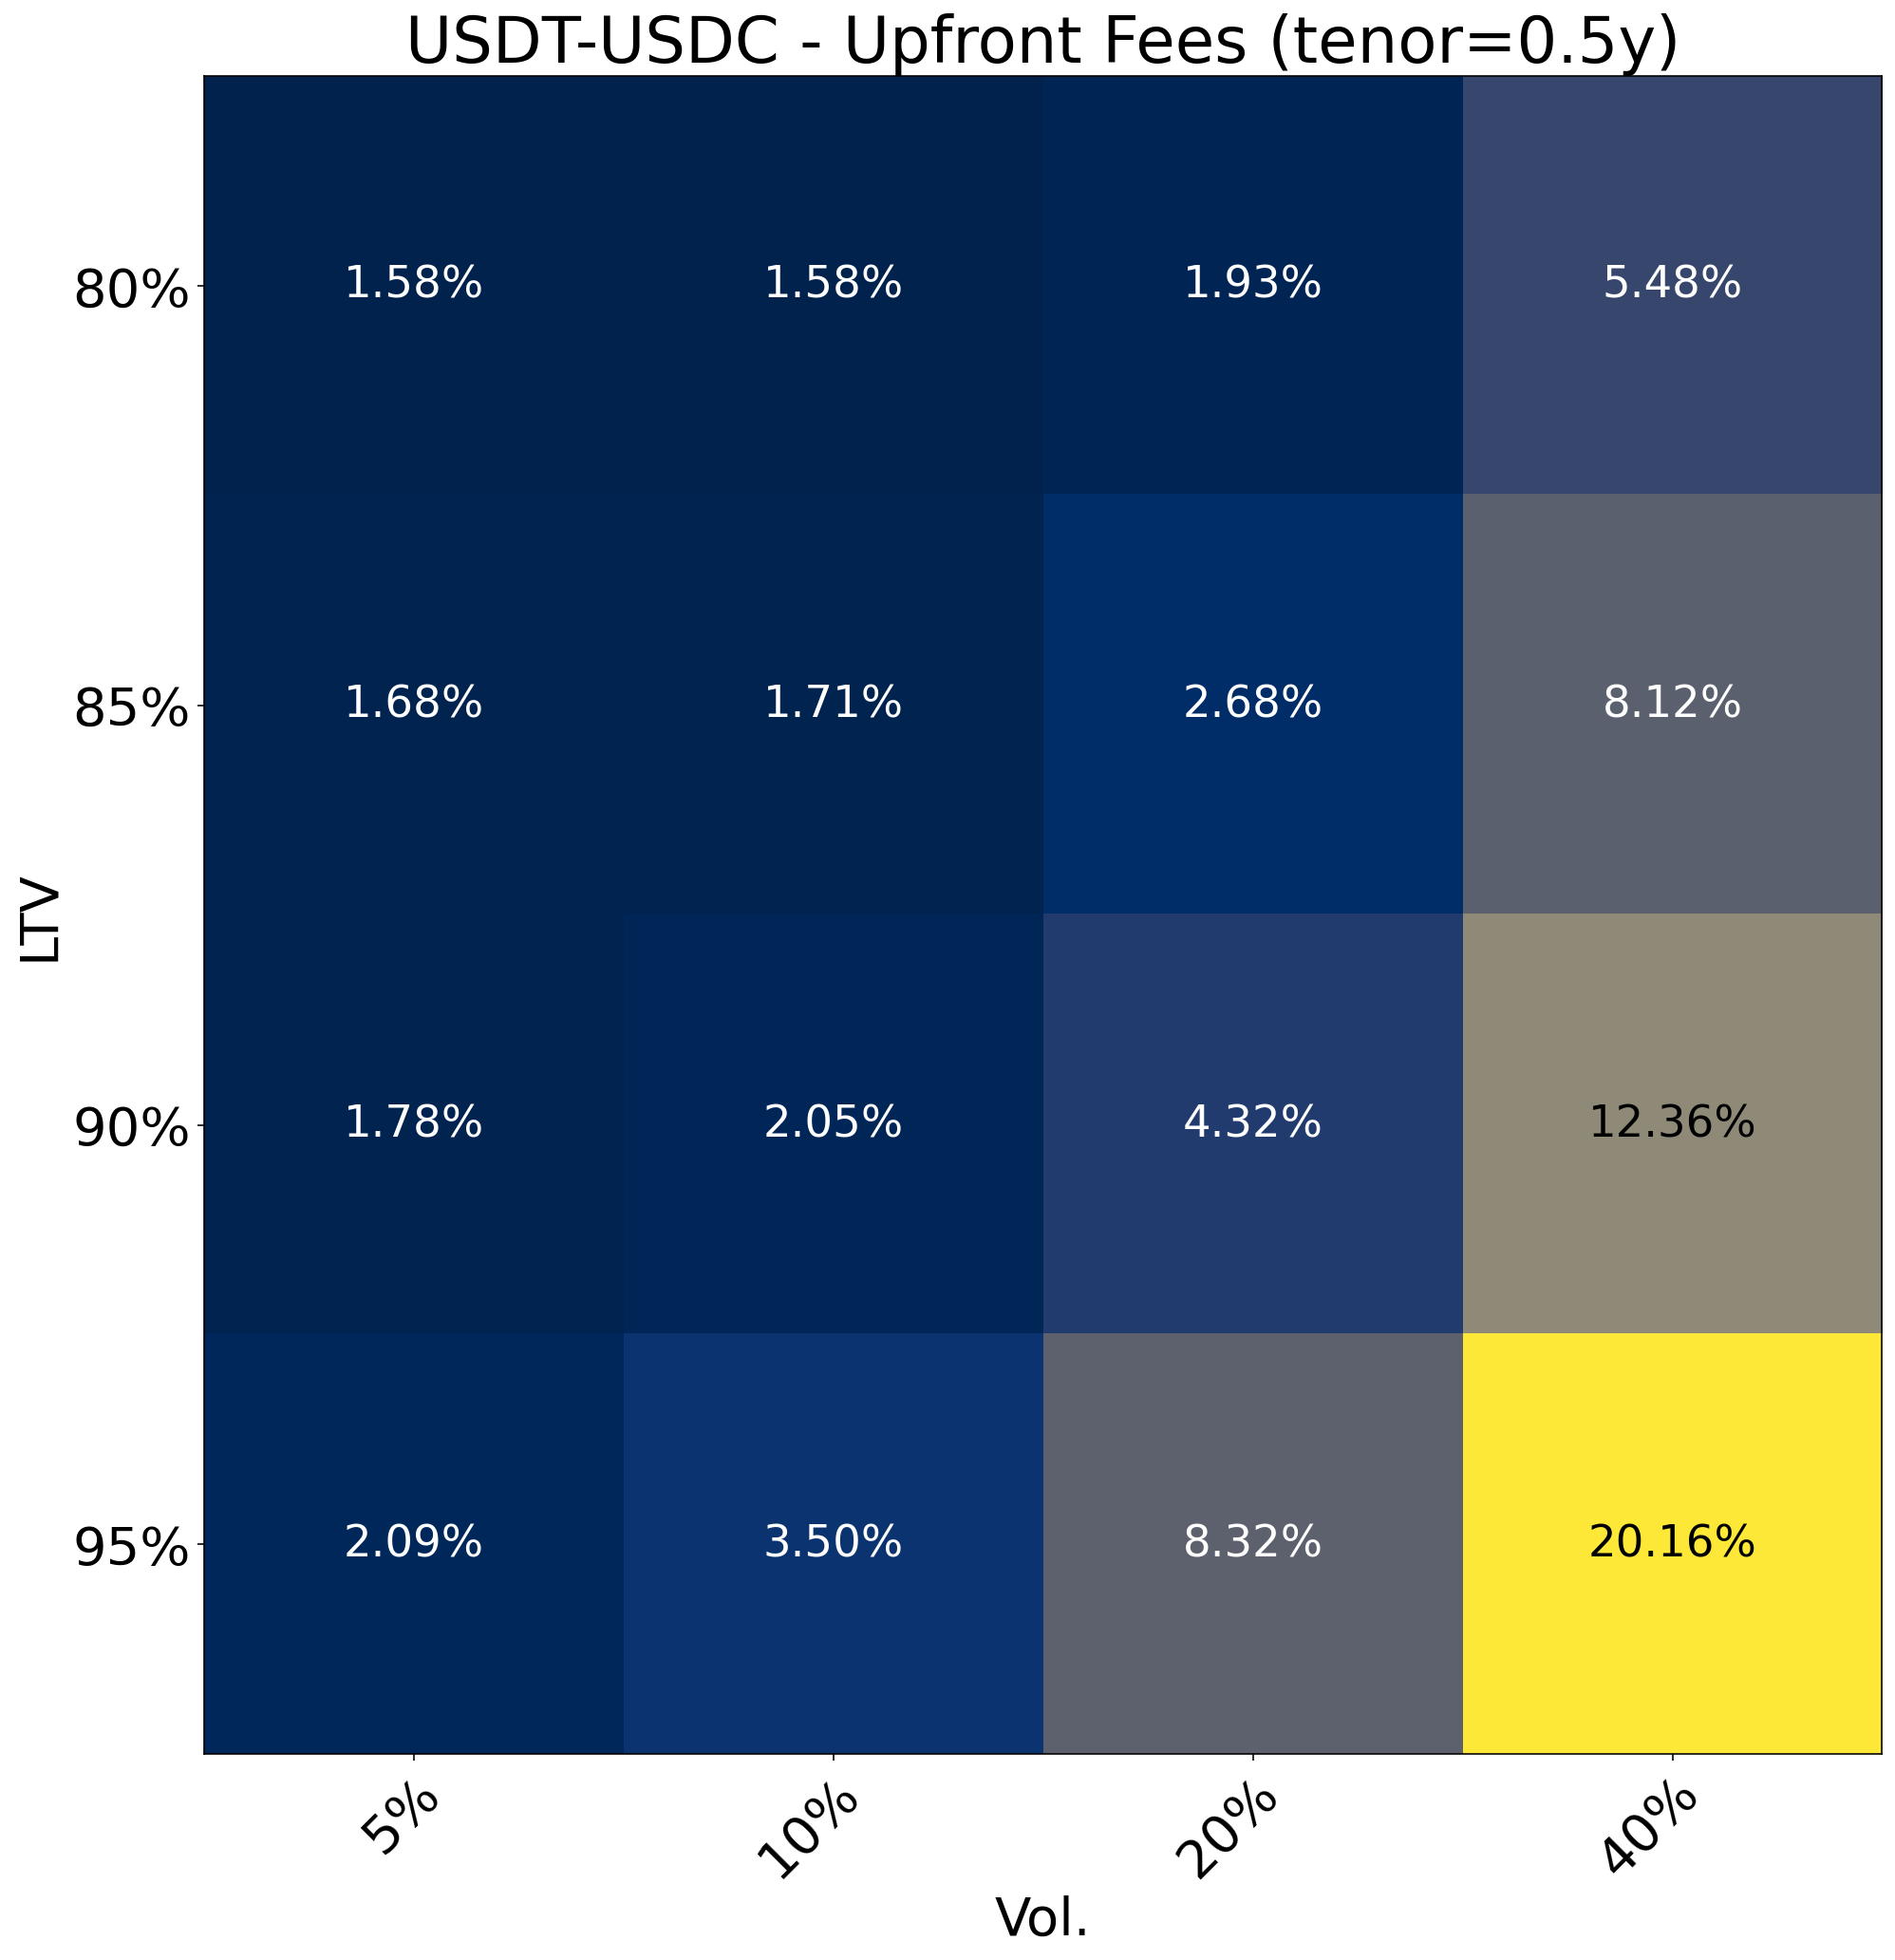

<Figure size 864x504 with 0 Axes>

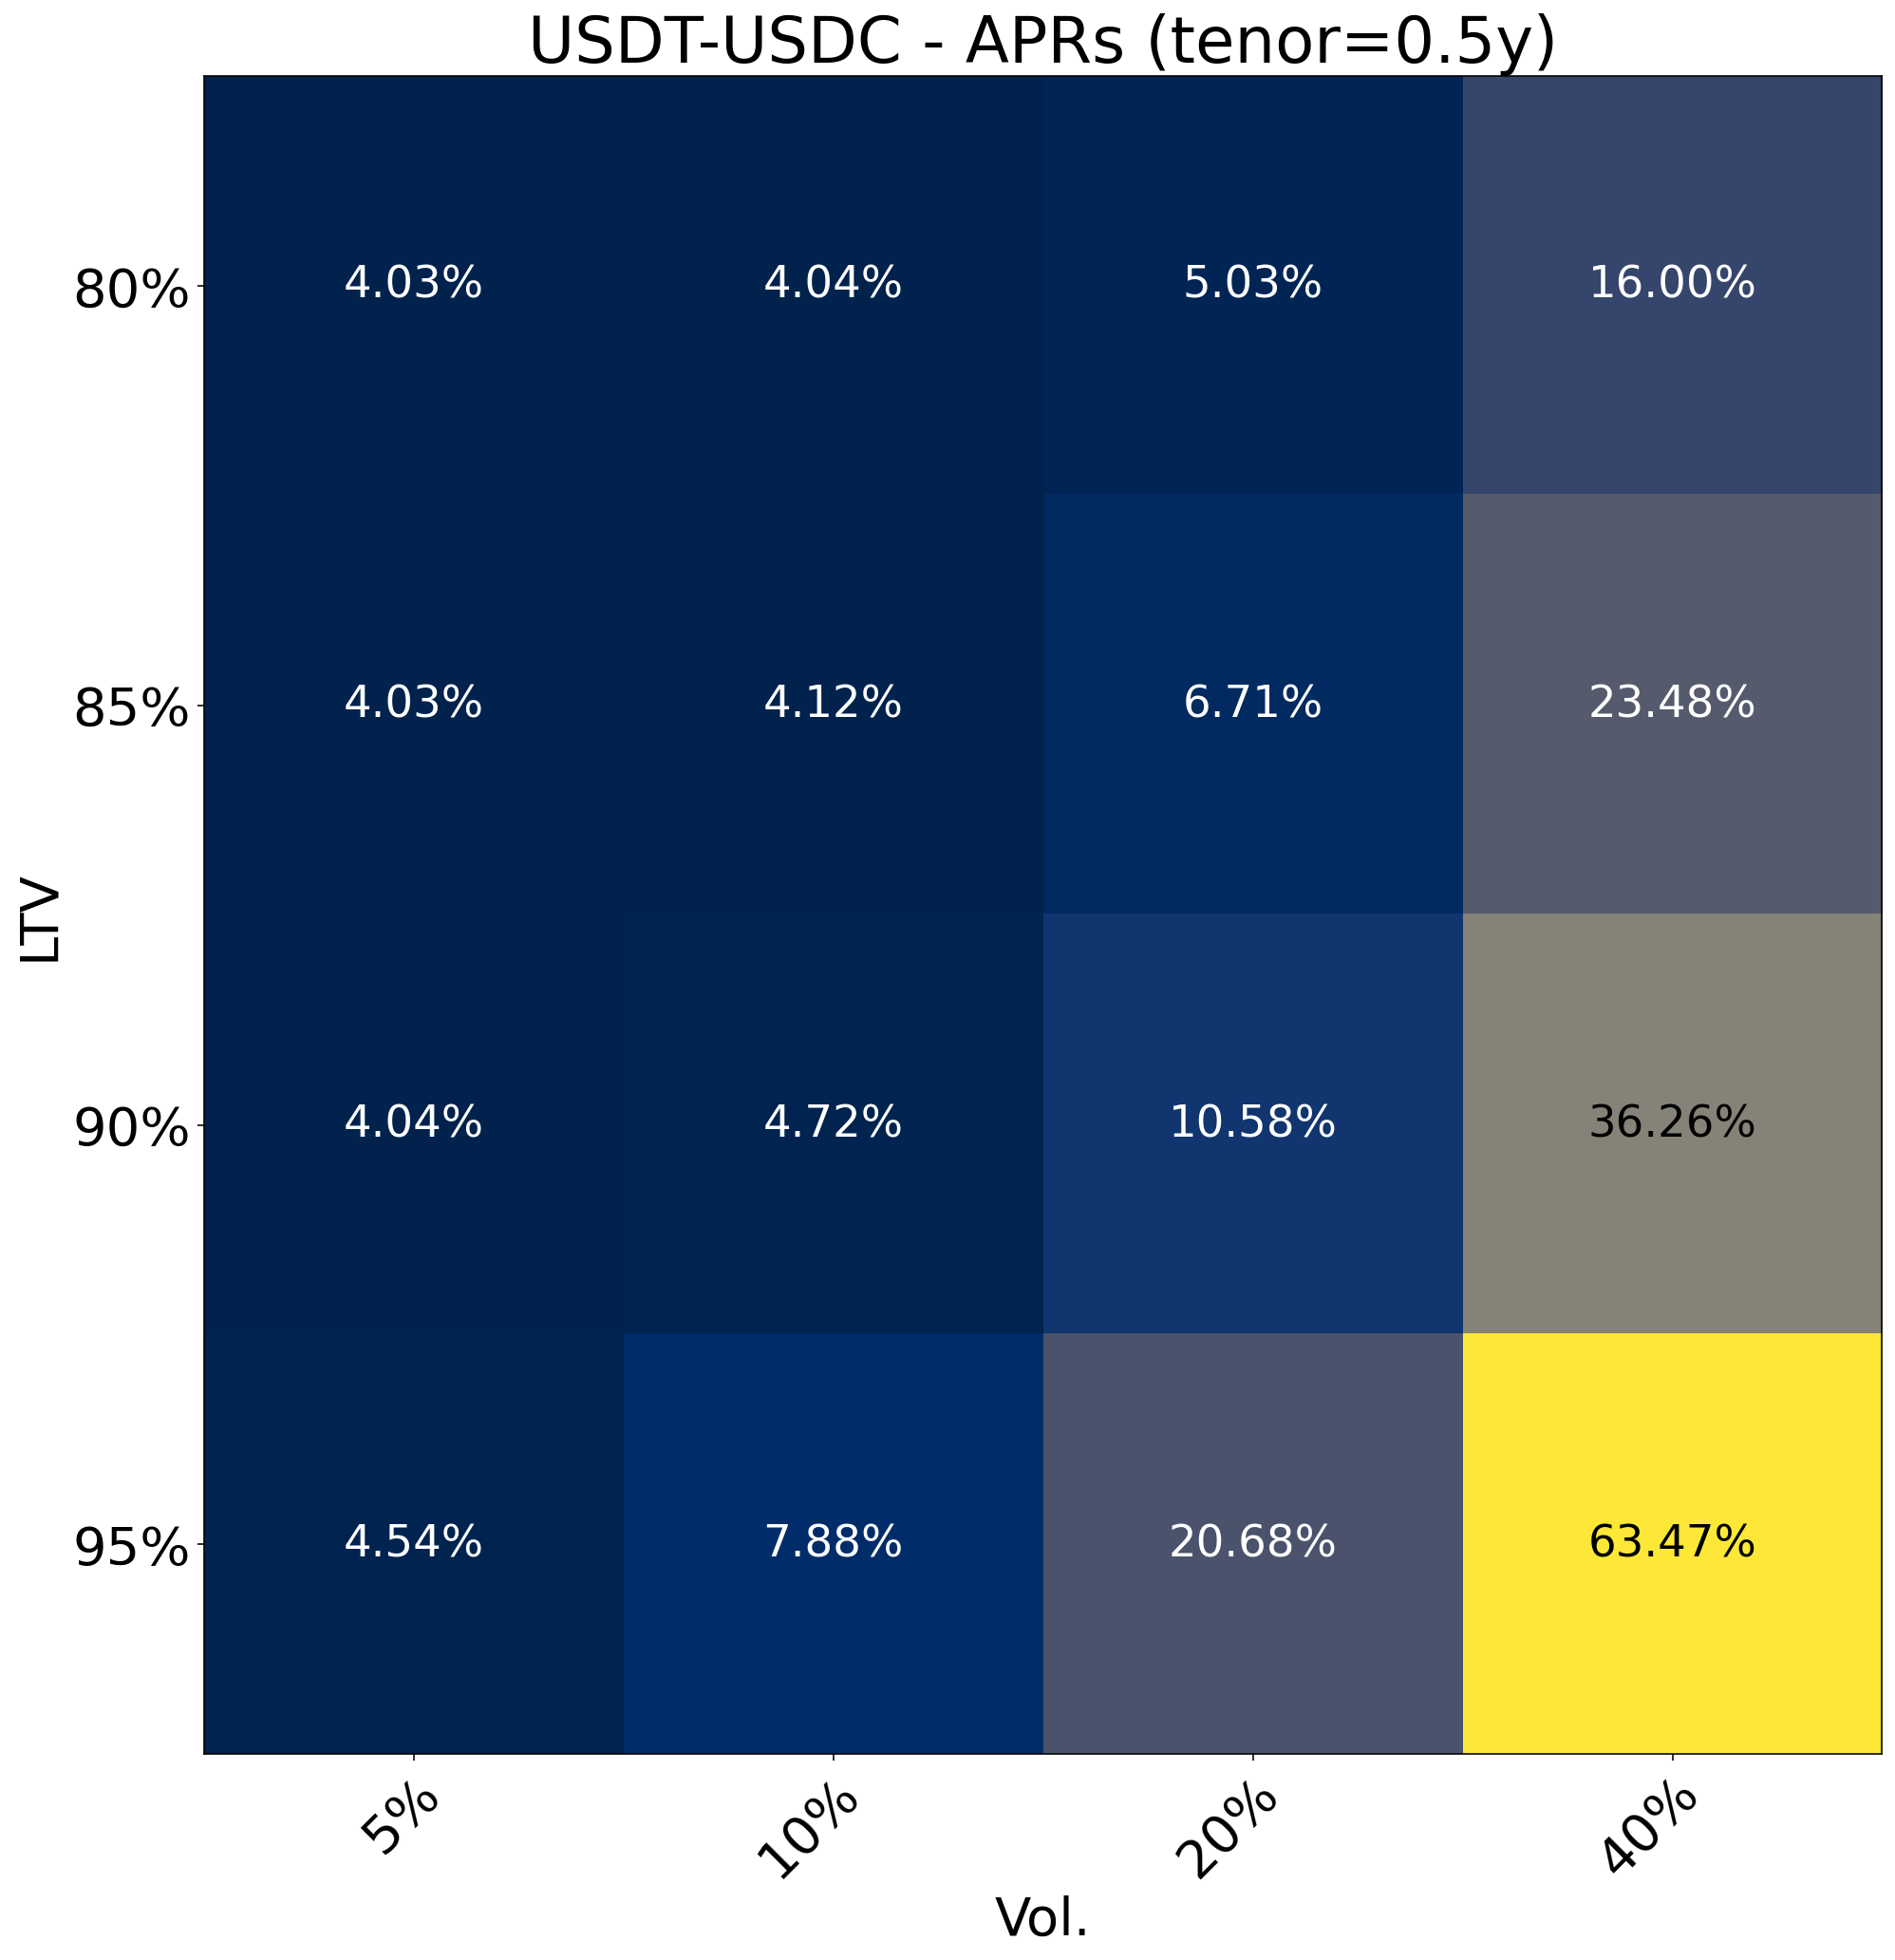

<Figure size 864x504 with 0 Axes>

In [5]:
import numpy as np
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt

CMAP = "cividis"

def getD1(S, K, vol, dt, r):
    return (np.log(S / K) + (r + vol**2 / 2) * dt) / \
        (vol * np.sqrt(dt))

def getCallPrice(spotPrice, strikePrice, vol, dt,riskFreeRate):
    if dt <= 0:
        return max([0, spotPrice - strikePrice])
    if strikePrice <= 0:
        return spotPrice
    d1 = getD1(spotPrice, strikePrice, vol, dt, riskFreeRate)
    d2 = d1 - vol * np.sqrt(dt)
    value = spotPrice * norm.cdf(d1) - strikePrice * \
        np.exp(-riskFreeRate * dt) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return value, delta

def getFairApr(ltv, loanTenorInYears, spotPrice, vol, riskFreeRate):
    def minFunc(strike):
        y = spotPrice*ltv
        callPrice, _ = getCallPrice(spotPrice, strike, vol, loanTenorInYears, riskFreeRate)
        z = spotPrice - callPrice - y*(1+riskFreeRate*loanTenorInYears)
        return z**2

    initStrikeGuess = spotPrice
    strikeBnds = (.0000001, None)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initStrikeGuess],
        bounds=[strikeBnds])

    if res["success"] and res["fun"] < 0.001:
        y = ltv*spotPrice
        strike = res['x'][0]
        apr = (strike/y-1)/loanTenorInYears
        return apr
    return None

def getFairFee(ltv, loanTenorInYears, spotPrice, vol, riskFreeRate):
    def minFunc(fee):
        y = spotPrice*ltv
        callPrice, _ = getCallPrice(spotPrice, y/(1-fee), vol, loanTenorInYears, riskFreeRate)
        z = (1-fee)*spotPrice - (1-fee)*callPrice - (y - fee*spotPrice)*(1+riskFreeRate*loanTenorInYears)
        return z**2

    maxFee = ltv
    initFeeGuesses = np.linspace(0.01, maxFee, 10)
    for initFeeGuess in initFeeGuesses:
        feeBnds = (.0, ltv)
        res = optimize.minimize(
            minFunc,
            args=(),
            x0=[initFeeGuess],
            bounds=[feeBnds])

        if res["success"] and res["fun"] < 0.001:
            fee = res['x'][0]
            return fee

    return None


def upfrontFeeHeatmap(params):
    feeRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["ltv"] = ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("ltv", "loanTenorInYears", "spotPrice", "riskFreeRate"))
            args["vol"] = vol
            fee = getFairFee(**args)
            tmp.append(fee)
        feeRes.append(tmp)

    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(feeRes, cmap=CMAP)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(feeRes), vmax=np.max(feeRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(feeRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(feeRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")

    ax.set_title("{} - Upfront Fees (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - fees.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()

def aprHeatmap(params):
    aprRes = []
    for ltv in params["ltvRange"]:
        tmp = []
        params["ltv"] = ltv
        for vol in params["volRange"]:
            args = dict((k, params[k]) for k in ("ltv", "loanTenorInYears", "spotPrice", "riskFreeRate"))
            args["vol"] = vol
            apr = getFairApr(**args)
            tmp.append(apr)
        aprRes.append(tmp)

    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    cmap = plt.cm.get_cmap(CMAP)
    ax.imshow(aprRes, cmap=CMAP)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(params["volRange"])), labels=["{:.0f}%".format(x*100) for x in params["volRange"]])
    ax.set_yticks(np.arange(len(params["ltvRange"])), labels=["{:.0f}%".format(x*100) for x in params["ltvRange"]])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(aprRes), vmax=np.max(aprRes))
    for i in range(len(params["ltvRange"])):
        for j in range(len(params["volRange"])):
            bg = cmap(normColors(aprRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            ax.text(j, i, "{:.2f}%".format(aprRes[i][j]*100),
                    ha="center", va="center", color=c, fontsize="smaller")

    ax.set_title("{} - APRs (tenor={:.1f}y)".format(params["pair"], params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
    fig.savefig('{} - aprs.png'.format(params["pair"]), dpi=fig.dpi)
    plt.clf()


params = {
    "pair": "USDT-USDC",
    "ltvRange": [.8, .85, .9, .95],
    "volRange": [.05, .1, .2, .4],
    "spotPrice": 1.,
    "riskFreeRate": .02,
    "loanTenorInYears": 1./2
}
upfrontFeeHeatmap(params)
aprHeatmap(params)
